[![image.png](https://i.postimg.cc/3NS5z6RB/image.png)](https://postimg.cc/V0CVCKXr)

Few days back I watched a show on Netflix named, [The Surgeon's Cut](https://www.youtube.com/watch?v=Fft5igeEIEM) and episode 2 intrigued me. This episode features Dr. Alfredo Quiñones-Hinojosa, one of the leading neurosurgeon who's expertise lies in removing complex brain tumors. 

One of the line he said in the episode which really gripped me and I quote, "The brain wasn't meant to be opened. It's not natural what we do. It's us defying nature. Opening the skull is scared and then cutting through the dura, the delicate membrane that is like the final gateway into a secret temple [brain]."

If you think about it this competition enables us to help reduce the sugeries required to perform an biopsy to determine if there is a tumor or not. What excites me the most is the fact that we humans are capable of course correcting the natural progression of our body.

MRI gives us an indirect way to look into our brain to find the defects and remove them hopefully to extend a human life. If we can develop algorightms that can improve the survival rate from less than a year to atleast two years, in my opinion it's giving a human being opportunities to connect with his/her family, do what's necesary for them and leave behind a legacy. 

------------------------------------------------------------------------------------------------------------------

In this kernel, I want to perform some basic EDA and use [Weights and Biases](https://wandb.ai/site) to visualize the data interactively. The idea is to understand the best way to present the data to make it more intuitive for everyone to get started with this competition. 



# 🌍 Imports and Setup

In [1]:
!pip install -q pydicom

In [3]:
import os
import re 
import glob
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Pydicom related imports
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import SimpleITK as sitk


# Deep learning packages
import tensorflow as tf

# For gif creation
import imageio

<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />

Weights & Biases (W&B) is a set of machine learning tools that helps you build better models faster. **Kaggle competitions require fast-paced model development and evaluation**. There are a lot of components: exploring the training data, training different models, combining trained models in different combinations (ensembling), and so on.

> ⏳ Lots of components = lots of places to go wrong = lots of time spent debugging 

W&B can be useful for Kaggle competition with it's lightweight and interoperable tools:

* quickly track experiments,<br>
* version and iterate on datasets, <br>
* evaluate model performance,<br>
* reproduce models,<br>
* visualize results and spot regressions,<br>
* and share findings with colleagues.

To learn more about Weights and Biases check out this [kernel](https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases).

In [4]:
# W&B for experiment tracking
import wandb
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

> You can learn more about using W&B in this introduction kernel, [Experiment Tracking with Weights and Biases](https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases).

In [5]:
CONFIG = {'IMG_SIZE': 224, 
          'NUM_FRAMES': 14,
          'competition': 'rsna-miccai-brain', 
          '_wandb_kernel': 'ayut'}

# 🌱 Training Data

The dataset consist of 585 patients and are given by unique id,`BraTS21ID`. You can also consider them independent cases. 

Each case consists of four structural multi-parametric MRI (mpMRI) scans. These scans are - 

* Fluid Attenuated Inversion Recovery (FLAIR) <br>
* T1-weighted pre-contrast (T1w)
* T1-weighted post-contrast (T1Gd)
* T2-weighted (T2)

Each sub-folder contains multiple scans in Dicom format with name - `Image-X.dcm`. Here X increases from 1 to N. **Each scan can be considered a slice (plane) of the brain**. We will investigate this further. 

Glioblastoma is a life-threatning brain tumor which is caused by the presence of a specific genetic sequence in the tumor known as MGMT promoter methylation. **Each independent case (patient) is labeled with `MGMT_value`. 1 corresponds to the presence of MGMT promoter and 0 corresponds to absense.**

In [6]:
train_df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
print('Number of rows: ', len(train_df))
train_df.head()

Number of rows:  585


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


1    307
0    278
Name: MGMT_value, dtype: int64


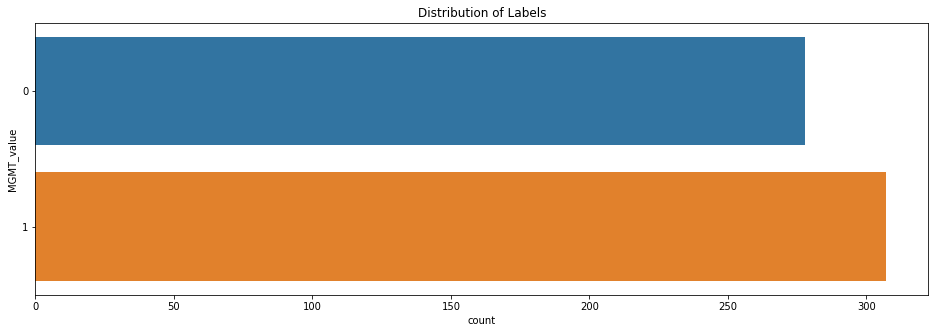

In [7]:
plt.figure(figsize=(16, 5))
ax = sns.countplot(data=train_df, y="MGMT_value")
ax.set_title("Distribution of Labels");
print(train_df.MGMT_value.value_counts())

> The dataset is not entirely balanced but the imbalance is not severe in the patient-level. 

### Let's look at the number of files (`.dcm`) we have.

In [8]:
filenames = glob.glob('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/*/*/*')
print(f'Total number of files: {len(filenames)}')

Total number of files: 348641


### Let's look at the distribution of files per scan types. 

In [9]:
label_dict = {
    'FLAIR': [],
    'T1w': [],
    'T1wCE': [],
    'T2w': []
}

for filename in tqdm(filenames):
    scan = filename.split('/')[-2]
    if scan=='FLAIR':
        label_dict['FLAIR'].append(filename)
    elif scan=='T1w':
        label_dict['T1w'].append(filename)
    elif scan=='T1wCE':
        label_dict['T1wCE'].append(filename)
    else:
        label_dict['T2w'].append(filename)
        
print('Size of FLAIR scan: {}, T1w scan: {}, T1wCE scan: {}, T2w scan: {}'.format(len(label_dict['FLAIR']), 
                                                                                  len(label_dict['T1w']),
                                                                                  len(label_dict['T1wCE']),
                                                                                  len(label_dict['T2w'])))

100%|██████████| 348641/348641 [00:00<00:00, 732497.30it/s]

Size of FLAIR scan: 74248, T1w scan: 77627, T1wCE scan: 96766, T2w scan: 100000


In [ ]:
run = wandb.init(project='brain-tumor-viz', config=CONFIG)
data = [['FLAIR', 74248], ['T1w', 77627], ['T1wCE', 96766], ['T2w', 100000]]
table = wandb.Table(data=data, columns = ["Scan Type", "Num Files"])
wandb.log({"my_bar_chart_id" : wandb.plot.bar(table, "Scan Type", "Num Files",
                               title="Scan Types vs Number of Dicom files")})
run.finish()

### [Interactive W&B Bar Chart $\rightarrow$](https://wandb.ai/ayush-thakur/brain-tumor-viz/runs/3se9o0ot)

![img](https://i.ibb.co/QNjHyQd/W-B-Chart-7-16-2021-3-49-04-AM.png)

# 🌊 MRI and Scan Types

Credit: The below text is derived from this excellent post titled, [Magnetic Resonance Imaging (MRI) of the Brain and Spine: Basics](https://case.edu/med/neurology/NR/MRI%20Basics.htm)

> Magnetic resonance imaging (MRI) is one of the most commonly used tests in neurology and neurosurgery. MRI provides exquisite detail of brain, spinal cord and vascular anatomy, and has the advantage of being able to visualize anatomy in all three planes: axial, sagittal and coronal (see the example image below). 

![img](https://i.ibb.co/S0wCMqc/image.png)

A powerful magnetic field is employed to align the protons that are normally randomly oriented within the water nuclei of the tissue being examined (in this case brain). This alignment (or magnetization) is next perturbed or disrupted by introduction of an external Radio Frequency (RF) energy. 

When the nuclei relaxes it emits RF signals (energy) which are measured. Fourier Transform is used to convert the frequency information contained in the signal from each location in the imaged plane to corresponding intensity levels, which are then displayed as shades of gray in a matrix arrangement of pixels. 

**By varying the sequence of RF pulses applied & collected, different types of images are created.**

* Repetition Time (TR) is the amount of time between successive pulse sequences applied to the same slice. <br>
* Time to Echo (TE) is the time between the delivery of the RF pulse and the receipt of the echo signal. 

**T1, T2 and FLAIR are different MRI Imaging Sequence that has pros and cons over each other.**

Check out this [discussion post](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/252843) by [dlbsabu](https://www.kaggle.com/dlbsabu) that explains the differences between different scan types.

This image compares different MRI Imaging sequences really well:

![img](https://i.ibb.co/5vZ4CgH/image.png)

*Note that FLAIR is very sensitive to pathology and makes the differentiation between CSF and an abnormality much easier. Also note that CSF stands for Cerebrospinal Fluid.*

### Read DICOM File

In [10]:
# Reference: https://www.kaggle.com/xhlulu/siim-covid-19-convert-to-jpg-256px
def ReadMRI(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

### Let's quickly test the function to read the DICOM file.

Shape of data:  (512, 512)


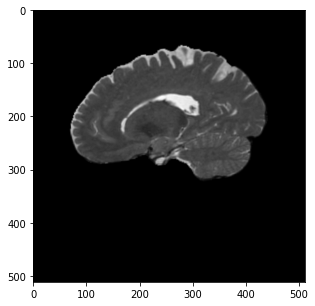

In [11]:
data = ReadMRI(filenames[11])
print('Shape of data: ', data.shape)

plt.figure(figsize=(5, 5))
plt.imshow(data, cmap='gray');

> Each MRI image has a resolution of 512x512 pixels. 

> There are some images without any useful content, i.e, there's no brainy stuff in the image.

# 🐋 Animate MRI Scan

As mentioned earlier, each subfolder within individual case corresponds to a MRI Imaging Sequence. We will use Weights and Biases image logging feature to log all the images in a  subfolder and will use a slider to animate the images to get a sense of 3D reconstruction of brain. 

Why am I using Weights and Biases for this? Well I could animate with just two lines of code and I can keep a log of all the scans that I animate to compare later. 

In [12]:
patient_ids = os.listdir('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train')
IDX = np.random.choice(len(patient_ids))

patient_id = patient_ids[IDX]
print(f'Patient ID: {patient_id}')

Patient ID: 00579


In [13]:
# https://stackoverflow.com/a/2669120/7636462
def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

### Let's animate FLAIR MRI Sequence

In [14]:
flair_data = []
flair_filenames = os.listdir(f'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{patient_id}/FLAIR/')
flair_filenames = sorted_nicely(flair_filenames)
for filename in flair_filenames:
    flair_data.append(ReadMRI(f'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{patient_id}/FLAIR/{filename}'))
    
print(f'Number of FLAIR images for the patient: {len(flair_data)}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


Number of FLAIR images for the patient: 62


In [ ]:
run = wandb.init(project='brain-tumor-viz', config=CONFIG)
wandb.log({f"flair_{patient_id}": [wandb.Image(image) for image in flair_data]})
run.finish()

### [Check out the run page $\rightarrow$](https://wandb.ai/ayush-thakur/brain-tumor-viz/runs/35x6onk7)
[![Animation.gif](https://i.postimg.cc/pXfL1VYV/Animation.gif)](https://postimg.cc/SJK4nhvH)

### Let's visualize different scan types for multiple patients with brain tumor.

In [ ]:
train_df_1 = train_df.loc[train_df.MGMT_value==1].reset_index(drop=True)
print(f'Number of patients with brain tumor: {len(train_df_1)}')

IMG_2_LOG = 20
train_df_1_sampled = train_df_1.sample(n=IMG_2_LOG).reset_index(drop=True)
print(f'Number of sampled patients: {len(train_df_1_sampled)}')

# Let's log the sampled dataframe to W&B Tables
sampled_data_at = wandb.Table(dataframe=train_df_1_sampled)

run = wandb.init(project='brain-tumor-viz', config=CONFIG)
wandb.log({f"Sampled Dataframe": sampled_data_at})
run.finish()

In [15]:
def get_patient_id(patient_id):
    if patient_id < 10:
        return '0000'+str(patient_id)
    elif patient_id >= 10 and patient_id < 100:
        return '000'+str(patient_id)
    elif patient_id >=100 and patient_id < 1000:
        return '00'+str(patient_id)
    else:
        return '0'+str(patient_id)

In [ ]:
for i in tqdm(range(len(train_df_1_sampled))):
    # Get Patient ID and directory name
    row = train_df_1_sampled.loc[i]
    patient_id = get_patient_id(row.BraTS21ID)
    
    # Initialize a W&B run to log images
    run = wandb.init(project='brain-tumor-viz', config=CONFIG, name=f'{patient_id}')

    for key in label_dict.keys():
        if os.path.isdir(f'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{patient_id}/{key}'):
            _filenames = os.listdir(f'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{patient_id}/{key}')
            _filenames = sorted_nicely(_filenames)
            for filename in _filenames:
                mri_data = ReadMRI(f'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{patient_id}/{key}/{filename}')
                # Log MRI data sequentially
                wandb.log({f'{key}': [wandb.Image(mri_data)]})

    # Close W&B run associated to that patient id.
    run.finish()

### [Check out the report to interact with the logged images $\rightarrow$](https://wandb.ai/ayush-thakur/brain-tumor-viz/reports/Visualize-MRI-Image-Sequence---Vmlldzo4NTcwMDk)
[![Animation2.gif](https://i.postimg.cc/wjZcSX9s/Animation2.gif)](https://postimg.cc/0zGwSJM8)

# ❄️ Create GIF using Imageio

Going forward, I am going to use the dataset created by [Jonathan Besomi](https://www.kaggle.com/jonathanbesomi). Many thanks to him for creating this. You can find the data [here](https://www.kaggle.com/jonathanbesomi/rsna-miccai-png).

In [16]:
processed_data_path = '../input/rsna-miccai-png/train'

In [17]:
# randomly select few samples for which we will create gifs using Imageio
sample_patients = np.random.choice(os.listdir(processed_data_path), 32)
sample_patient_paths = [f'{processed_data_path}/{sample}/T2w/' for sample in sample_patients]

In [18]:
def decode_image(image):
    # convert the compressed string to a 3D uint8 tensor
    image = tf.image.decode_png(image, channels=1)
    # Normalize image
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    return image

def parse_frames(dirname, window=False):
    # get MRI images file paths for given patient 
    paths = glob.glob(dirname+'/*.png')
    # Sort the images to get sequential imaging
    paths = sorted_nicely(paths)
    
    if window:
        # randomly select a window of images to be used as sequence
        start = tf.random.uniform((1,), maxval=len(paths)-CONFIG['NUM_FRAMES'], dtype=tf.int32)

        paths = tf.slice(paths, start, [CONFIG['NUM_FRAMES']])
    else:
        paths = tf.convert_to_tensor(paths)
        

    def get_frames(path):
        # Load image
        image = tf.io.read_file(path)
        image = decode_image(image)
        # Resize image
        image = tf.image.resize(image, (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']))
        
        return image

    mri_images = tf.map_fn(fn=get_frames, elems=paths, fn_output_signature=tf.float32)
    
    return mri_images

In [19]:
frames = []
for sample_path in tqdm(sample_patient_paths):
    frames.append(parse_frames(sample_path))

100%|██████████| 32/32 [00:35<00:00,  1.11s/it]


In [ ]:
run = wandb.init(project='brain-tumor-viz', config=CONFIG, job_type='create-gifs')

os.makedirs('tmp-gifs/', exist_ok=True)
for i, frame in tqdm(enumerate(frames)):
    imageio.mimsave(f'tmp-gifs/out_{i}.gif', (frame*255).numpy().astype('uint8'))    

wandb.log({'examples': [wandb.Image(f'tmp-gifs/out_{i}.gif') 
                        for i in range(len(frames))]})
    
run.finish()

### [Check out the W&B Run page here $\rightarrow$](https://wandb.ai/ayush-thakur/brain-tumor-viz/runs/2nrw339f)

![img](https://i.imgur.com/olT8gQK.gif)

# 🎉🎉 Visualizing dataset interactively with W&B Tables 🎆🎆

W&B Tables let you to log, query, and analyze data interactively. This can help you understand your dataset, visualize model predictions, and share insights in a central dashboard. 

The code cell below logs the entire dataset of this competition as GIFs (every MRI sequence) along with patient id and ground truth. 

### Why should you use W&B Tables?

* It is suited for quick EDA. 

* It helps understand the data better with few lines of code. Here's a [quick colab notebook](http://wandb.me/tables-quickstart).

* It lets you see the "actual" data in it's entirety. With matplotlib based visualization you will have to plot everything in batches and it not very scalable. 

* You can filter, sort and group data which can help answer some fundamental questions. 

* It is well suited to visualize model predictions and compare models on example level. You can check out this [Kaggle kernel](https://www.kaggle.com/ayuraj/better-data-understanding-with-w-b-tables) to learn more about model prediction visualization. 

Read more about Tables [here](https://wandb.ai/wandb/posts/reports/Announcing-W-B-Tables-Iterate-on-Your-Data--Vmlldzo4NTMxNDU).

In [ ]:
# Initialize a W&B run to log images
run = wandb.init(project='brain-tumor-viz', config=CONFIG, name='viz-dataset-tables') # W&B Code 1

data_at = wandb.Table(columns=['patient_id', 'target', 'FLAIR', 'T1w', 'T1wCE', 'T2w']) # W&B Code 2

for i in tqdm(range(len(train_df))):
    os.makedirs('tables-gif', exist_ok=True)
    
    row = train_df.loc[i]
    patient_id = get_patient_id(row.BraTS21ID)
    c = 0
    missed_keys = []
    for j, key in enumerate(label_dict.keys()):
        if os.path.isdir(f'../input/rsna-miccai-png/train/{patient_id}/{key}'):
            _frames = parse_frames(f'../input/rsna-miccai-png/train/{patient_id}/{key}')
            imageio.mimsave(f'tables-gif/out_{patient_id}_{j}.gif', (_frames*255).numpy().astype('uint8'))
            c += 1
        else:
            missed_keys.append(key)
    
    if c==4:
        data_at.add_data(patient_id,                                            
                         row.MGMT_value,
                         wandb.Image(f'tables-gif/out_{patient_id}_0.gif'),
                         wandb.Image(f'tables-gif/out_{patient_id}_1.gif'),
                         wandb.Image(f'tables-gif/out_{patient_id}_2.gif'),
                         wandb.Image(f'tables-gif/out_{patient_id}_3.gif')) # W&B Code 3
    else:
        print(f'Patient Id: {patient_id} is missing these MRI sequences: {missed_keys}')
        data_tuple = ()
        for j, key in enumerate(label_dict.keys()):
            if key not in missed_keys:
                data_tuple += (wandb.Image(f'tables-gif/out_{patient_id}_{j}.gif'),)
            else:
                data_tuple += (None,)
        
        data_at.add_data(patient_id, 
                         row.MGMT_value,
                         *data_tuple)

wandb.log({'MRI Sequencing Dataset': data_at}) # W&B Code 4
wandb.finish() # W&B Code 5

### Visualize entire dataset interactively

#### [Check out the table here $\rightarrow$](http://wandb.me/brain-tumor-tables)

[![Animation7414e590d7929f38.gif](https://s6.gifyu.com/images/Animation7414e590d7929f38.gif)](http://wandb.me/brain-tumor-tables)

# Connecting Voxel Spaces and Resampling

This section is based on the amazing work done by [Michael Beregov](https://www.kaggle.com/boojum) in his [kernel](https://www.kaggle.com/boojum/connecting-voxel-spaces).

In [43]:
TRAIN_PATH = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train'
folders = os.listdir(train_data)
folder = folders[0]

In [44]:
def read_dicom(file_id, scan_type):
    filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{TRAIN_PATH}/{file_id}/{scan_type}')
    reader.SetFileNames(filenamesDICOM)
    file = reader.Execute()
    return file

def resample(image, ref_image):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    
    resampler.SetTransform(sitk.AffineTransform(image.GetDimension()))

    resampler.SetOutputSpacing(ref_image.GetSpacing())

    resampler.SetSize(ref_image.GetSize())

    resampler.SetOutputDirection(ref_image.GetDirection())

    resampler.SetOutputOrigin(ref_image.GetOrigin())

    resampler.SetDefaultPixelValue(image.GetPixelIDValue())

    resamped_image = resampler.Execute(image)
    
    return resamped_image

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [31]:
reader = sitk.ImageSeriesReader()
reader.LoadPrivateTagsOn()
filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{train_path}/{folder}/T1w')
reader.SetFileNames(filenamesDICOM)
t1_reference = reader.Execute()

In [50]:
reader = sitk.ImageSeriesReader()
reader.LoadPrivateTagsOn()

# read FLAIR scan
flair = read_dicom(folder, 'FLAIR')

# read T1wCE scan
t1wce = read_dicom(folder, 'T1wCE')

# read T2w scan
t2 = read_dicom(folder, 'T2w')

# resampled
flair_resampled = resample(flair, t1_reference)
flair_resampled = normalize(sitk.GetArrayFromImage(flair_resampled))

t1wce_resampled = resample(t1wce, t1_reference)
t1wce_resampled = normalize(sitk.GetArrayFromImage(t1wce_resampled))

t2_resampled = resample(t2, t1_reference)
t2_resampled = normalize(sitk.GetArrayFromImage(t2_resampled))

stacked = np.stack([t1wce_resampled, t2_resampled, flair_resampled])

to_rgb = stacked[:,100,:,:].transpose(1,2,0)
im = Image.fromarray((to_rgb * 255).astype(np.uint8))

In [52]:
run = wandb.init(project='brain-tumor-viz', config=CONFIG)

for i in range(stacked.shape[1]):
    to_rgb = stacked[:,i,:,:].transpose(1,2,0)
    im = Image.fromarray((to_rgb * 255).astype(np.uint8))
    wandb.log({f"stacked_{folder}": [wandb.Image(im)]})
    
run.finish()

wandb: Currently logged in as: ayush-thakur (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


_runtime,9
_timestamp,1629061006
_step,213


_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


# WORK IN PROGRESS